In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

end = '2016-04-03'
start = '2015-04-03'

trip_temps = calc_temps(start,end)

print(f'The min, avg and max temperatures between {end} and {start} are:\
{trip_temps[0][0]}, {trip_temps[0][1]} and {trip_temps[0][2]}')

The min, avg and max temperatures between 2016-04-03 and 2015-04-03 are:56.0, 74.28028704094555 and 86.0


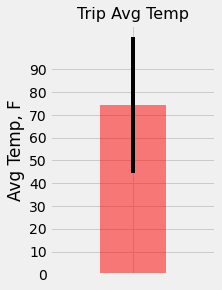

In [16]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp = trip_temps[0][1]
x_axis = [1]
yerr = trip_temps[0][2] - trip_temps[0][0]
ytick_s = range(0,100,10)
fig = plt.figure(figsize = (3,4))

plt.bar(x_axis, temp, color='r', alpha=0.5, align="center", yerr = yerr)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, "")
plt.xlim(0,2)

plt.yticks(ytick_s)
plt.tight_layout()
plt.title("Trip Avg Temp", fontsize = 16)
plt.ylabel("Avg Temp, F")
fig.savefig('Images/temperatures.png')

### Daily Rainfall Average

In [17]:
# Take another look at Measurement keys
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x224dbb71240>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

In [19]:
# Take another look at Station keys
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x224dbb71710>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [29]:
# Perform a join of the two data sets to incorporate long, lat data
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Measurement.tobs, Measurement.prcp, Station.longitude,
       Station.latitude, Station.elevation]

same_station = session.query(*sel, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).\
                filter(Measurement.date >= start).filter(Measurement.date <= end).\
                group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

same_station

[('USC00517948',
  'PEARL CITY, HI US',
  78.0,
  0.04,
  -157.9751,
  21.3934,
  11.9,
  3.3000000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  77.0,
  0.0,
  -157.71139,
  21.33556,
  19.5,
  51.48999999999999),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  72.0,
  0.0,
  -157.8168,
  21.2716,
  3.0,
  16.05999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  74.0,
  0.0,
  -157.84888999999998,
  21.45167,
  32.9,
  81.48999999999995),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  77.0,
  0.0,
  -157.8374,
  21.5213,
  7.0,
  42.18999999999998),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  74.0,
  0.0,
  -157.8015,
  21.4234,
  14.6,
  53.7),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  77.0,
  0.0,
  -157.9992,
  21.3152,
  0.9,
  4.620000000000001),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  72.0,
  None,
  -158.0111,
  21.4992,
  306.6,
  0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  70.0,
  None,
  -

In [56]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [75]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

start = dt.datetime.strptime(start_date,'%Y-%m-%d')
end = dt.datetime.strptime(end_date,'%Y-%m-%d')

# Use the start and end date to create a range of dates
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

date = [str(date_generated[index].month) + '-' + str(date_generated[index].day) for index, day in enumerate(date_generated)]

In [84]:
date_str = dt.datetime.strptime(date[0],"%m-%d")
print(date[0])
print(daily_normals(date[0]))
print(type(date[0]))
print(date_str)
print(type(date_str))
daily_normals(date_str)

8-1
[(None, None, None)]
<class 'str'>
1900-08-01 00:00:00
<class 'datetime.datetime'>


[(None, None, None)]

In [73]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`
normals = []
# normals = [normals.append(daily_normals(date[index])) for index, date in enumerate(date)]
normals = [normals.append(daily_normals(date[x])) for x in range(len(date))]
normals

[None, None, None, None, None, None]

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session